## Edge handling experiments

For background on the derivation of the Richardson Lucy equation for non-circulant boundaries see [this Application note](http://bigwww.epfl.ch/deconvolution/challenge2013/index.html?p=doc_math_rl)

When image is extended we can think of it being equivalent to extending our 'solution space'.  Then the acquired image has been multiplied by a window w in the larger space.  And the RL equation becomes.

$$
    {o}_{k+1} = \frac{o_{k}\left[\frac{wi}{o_{k}*h}*h^*\right]}{n}
$$

Where ```n``` is a normalization factor calculated as ```HTones```.  The ```H``` operator on the image is convolution followed by multiplication by a window

$$
measuredimage=w(h*reality)
$$

So ```HTones``` would be window applied to the ```ones``` matrix followed by convolution by the conjugate of the PSF. 

$$
(w(ones))*h^*
$$



## Create an environment

In this environment we will install some tools we need for decon, this includes Jupyter noteook, clij2fft for non-circulant Richardson Lucy, devbio version of Napari for visualization, sdeconv for theoretical PSF, tnia-python for XYZ projected figures in the notebook. 
```
    conda create --name decon-env python=3.9
    conda activate decon-env
    pip install devbio-napari
    pip install git+https://github.com/True-North-Intelligent-Algorithms/tnia-python
    pip install napari-sdeconv
    pip install --index-url https://test.pypi.org/simple/ --no-deps clij2-
```

## Load the test image

Load the test image and crop the image a bit as to speed up testing.  We also reverse the z axis of the stack so that it is consistent with positive 'depth' being below the coverslip.

(50, 256, 256)


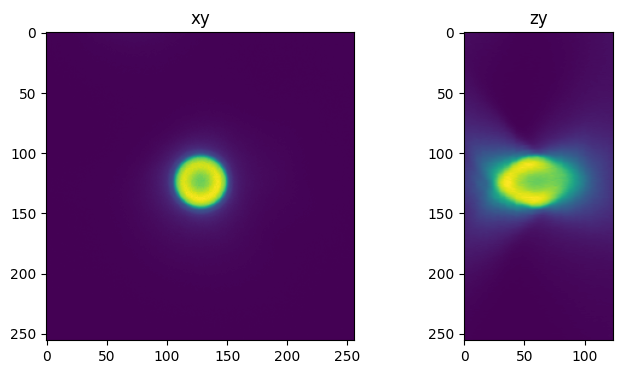

In [14]:
from skimage.io import imread
import numpy as np
from tnia.plotting.projections import show_xy_zy_slice

path_=r"D:\images\tnia-python-images\deconvolution\bead"

bead=imread(path_+"/Bead.tif")
z_start=75
z_end=125
z_to_view=(z_end-z_start)//2

roi=np.s_[z_start:z_end, :, :]
bead=bead[roi]
bead=bead[::-1,:,:]

xy_spacing = 0.0645
z_spacing=.16

ratio = z_spacing/xy_spacing

print(bead.shape)

fig=show_xy_zy_slice(bead,128,128,z_to_view, sz=ratio, figsize=(8,4))

## Create the PSF

Here we generate the PSF.  The meta data does not include the refractive index of the medium the bead is embedded in.  It is likely close to, but not exactly the refractive index of the lens immersion media, in a previous experiment we dtermined the RI of the embedding media to be apr. 1.49.  

sdeconv 1.x.x detected


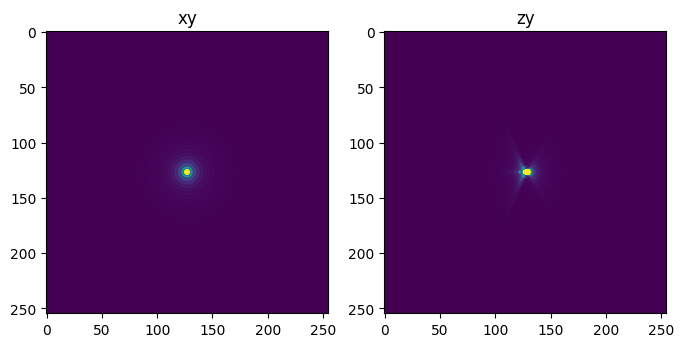

In [15]:
from tnia.nd.ndutil import centercrop
from tnia.deconvolution.psfs import gibson_lanni_3D
from tnia.plotting.projections import show_xy_zy_max
from tnia.deconvolution.psfs import recenter_psf_axial
from skimage.io import imsave

ni=1.518
ns  = 1.49
NA=1.4
w=0.530

xy_spacing = 0.0645
z_spacing=.16

xy_psf_dim=255
z_compute_psf_dim=599
z_crop_psf_dim=101

#depth to compute PSF at
d=128*z_spacing

psf  = gibson_lanni_3D(NA, ni, ns, xy_spacing, z_spacing, xy_psf_dim, z_compute_psf_dim, d, w)
psf = psf.astype('float32')

psf=recenter_psf_axial(psf, 255)
fig=show_xy_zy_max(psf, vmax=psf.max()/4, figsize=(8,4))

## Set deconvolution parameters

For the first experiment we deconvolve a centered bead for 2000 iterations.  Even though the bead is centered we still see artifacts when proper edge handling is not used. 

In [16]:
from clij2fft.richardson_lucy import richardson_lucy_nc
from tnia.deconvolution.richardson_lucy import richardson_lucy_cp
from tnia.deconvolution.fftdeconv import fftdeconv
import RedLionfishDeconv as rl

bead = bead.astype('float32')
regularization_factor=0
iterations=2000
psf_crop=centercrop(psf, (bead.shape[0], psf.shape[1], psf.shape[2]))

In [17]:

import RedLionfishDeconv as rl
decon_rl=rl.doRLDeconvolutionFromNpArrays(bead, psf_crop, niter=iterations, method='gpu', resAsUint8=False )

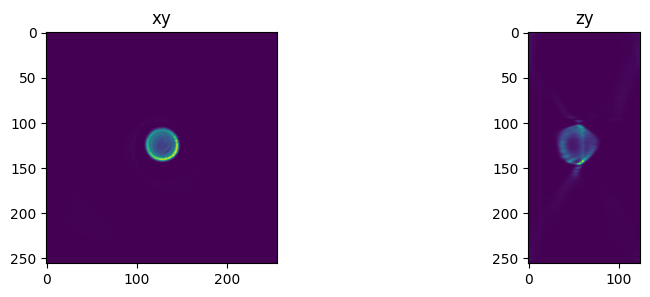

In [18]:
fig=show_xy_zy_slice(decon_rl,128,128,z_to_view, sz=ratio)

In [19]:
# renormalize psf
regularization_factor=0
psf_crop=psf_crop/psf_crop.sum()
im_decon_clij_nc = richardson_lucy_nc(bead, psf_crop, iterations , regularization_factor)
im_decon_cp= richardson_lucy_cp(bead, psf_crop, iterations , False)
im_decon_cp_nc = richardson_lucy_cp(bead, psf_crop, iterations , True)
im_fftdecon = fftdeconv(bead, psf_crop, iterations);
#im_decon= richardson_lucy_cp(bead, psf_crop, 5000 , False)
#im_decon_m = fftdeconv(bead, psf_crop, 2000)

get lib
padding psf

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500 1510 1520 1530 1540 1550 1560 1570 1580 1590 1600 1610 1620 1630 1640 1650 1660 1670 1680 1690 1700 1710 1720 1730 1740 1750 1760 1770 1780 1790 1800 1810 1820 1830 1840 1850 1860 1870 1880 1890 1900 1910 1920 1930 1940 1950 1960 1970 1980 1990 

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240

Text(0.5, 0.98, 'decon fftdeconv')

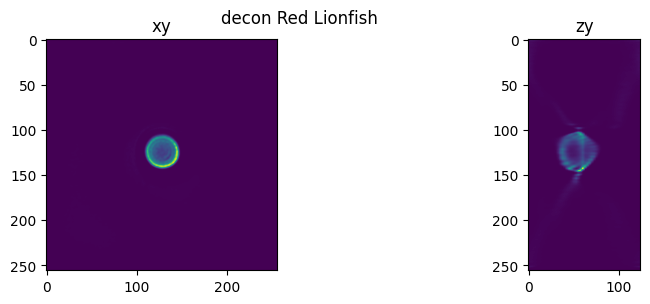

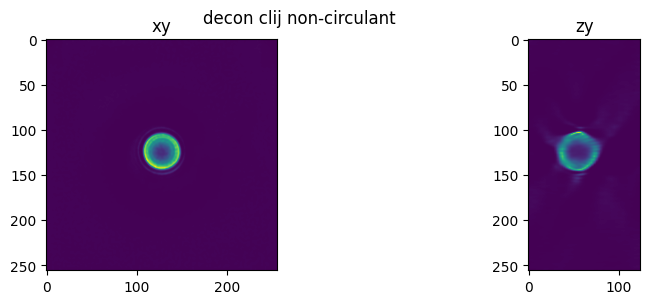

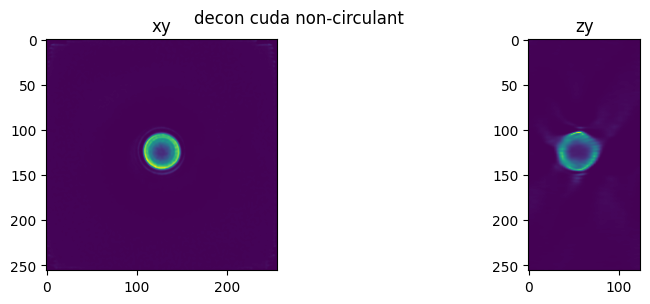

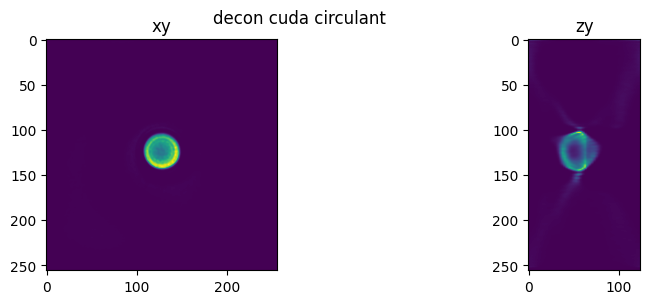

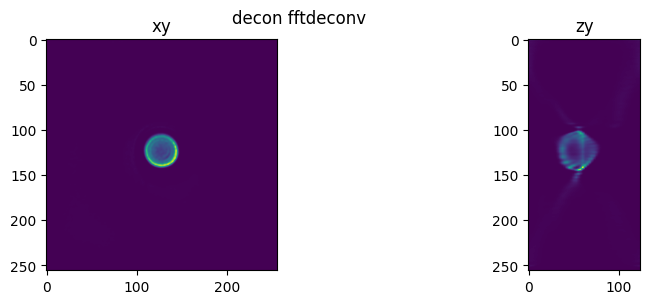

In [21]:

fig=show_xy_zy_slice(decon_rl,128,128,z_to_view, sz=ratio)
fig.suptitle('decon Red Lionfish')
fig=show_xy_zy_slice(im_decon_clij_nc,128,128,z_to_view, sz=ratio)
fig.suptitle('decon clij non-circulant')
fig=show_xy_zy_slice(im_decon_cp_nc,128,128,z_to_view, sz=ratio)
fig.suptitle('decon cuda non-circulant')
fig=show_xy_zy_slice(im_decon_cp,128,128,z_to_view, sz=ratio)
fig.suptitle('decon cuda circulant')
fig=show_xy_zy_slice(im_fftdecon,128,128,z_to_view, sz=ratio)
fig.suptitle('decon fftdeconv')

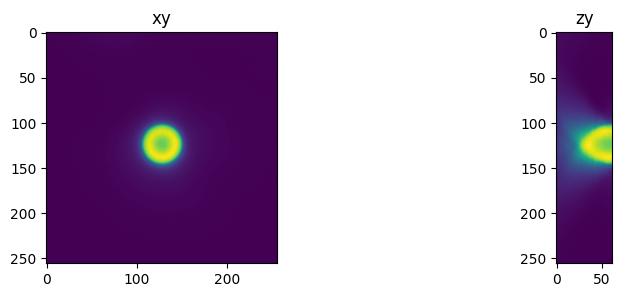

In [24]:
half_bead=bead[:bead.shape[0]//2,:,:]
z_to_view=half_bead.shape[0]-1
fig=show_xy_zy_slice(half_bead,128,128,z_to_view, sz=ratio)

In [25]:

psf_crop=centercrop(psf, (half_bead.shape[0], psf.shape[1], psf.shape[2]))

In [30]:

decon_rl=rl.doRLDeconvolutionFromNpArrays(half_bead, psf_crop, niter=iterations, method='gpu', resAsUint8=False )

In [28]:

im_decon_clij_nc = richardson_lucy_nc(half_bead, psf_crop, iterations , regularization_factor)
im_decon_cp= richardson_lucy_cp(half_bead, psf_crop, iterations , False)
im_decon_cp_nc = richardson_lucy_cp(half_bead, psf_crop, iterations , True)
im_fftdecon = fftdeconv(half_bead, psf_crop, iterations);

get lib
padding psf

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500 1510 1520 1530 1540 1550 1560 1570 1580 1590 1600 1610 1620 1630 1640 1650 1660 1670 1680 1690 1700 1710 1720 1730 1740 1750 1760 1770 1780 1790 1800 1810 1820 1830 1840 1850 1860 1870 1880 1890 1900 1910 1920 1930 1940 1950 1960 1970 1980 1990 

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240

Text(0.5, 0.98, 'decon fftdeconv')

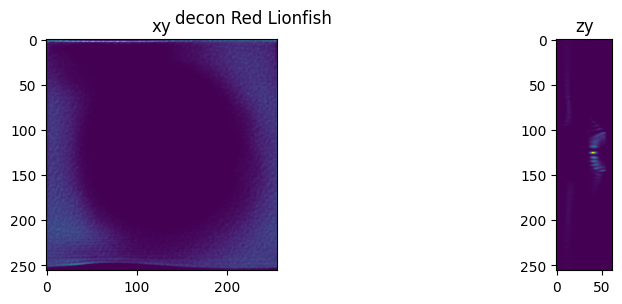

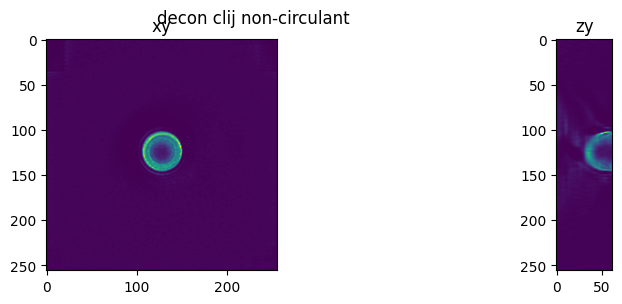

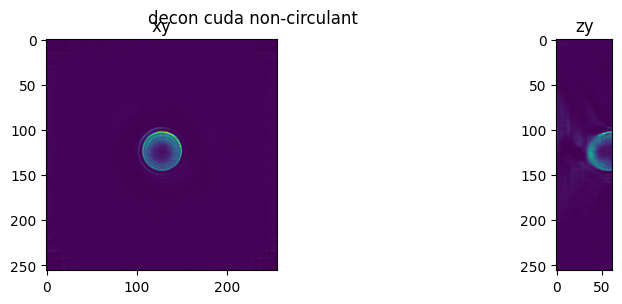

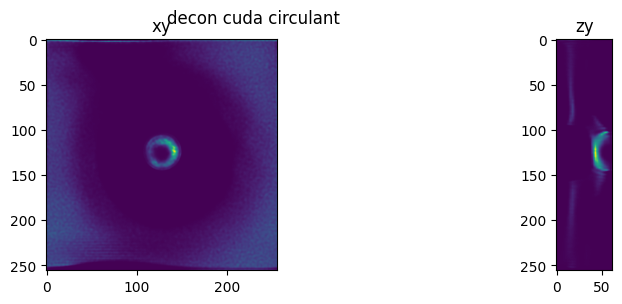

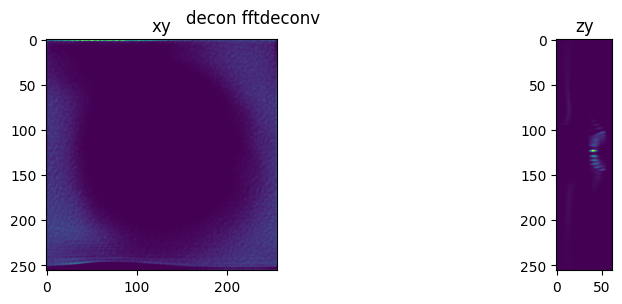

In [31]:
fig=show_xy_zy_slice(decon_rl,128,128,z_to_view, sz=ratio)
fig.suptitle('decon Red Lionfish')
fig=show_xy_zy_slice(im_decon_clij_nc,128,128,z_to_view, sz=ratio)
fig.suptitle('decon clij non-circulant')
fig=show_xy_zy_slice(im_decon_cp_nc,128,128,z_to_view, sz=ratio)
fig.suptitle('decon cuda non-circulant')
fig=show_xy_zy_slice(im_decon_cp,128,128,z_to_view, sz=ratio)
fig.suptitle('decon cuda circulant')
fig=show_xy_zy_slice(im_fftdecon,128,128,z_to_view, sz=ratio)
fig.suptitle('decon fftdeconv')

In [ ]:
import napari
viewer=napari.Viewer()

viewer.add_image(bead, scale=(z_spacing/xy_spacing,1,1))
viewer.add_image(im_decon, scale=(z_spacing/xy_spacing,1,1))

<Image layer 'im_decon' at 0x20f63b1cd00>